In [1]:
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(tidyr)))
suppressWarnings(suppressPackageStartupMessages(library(arrow)))
suppressWarnings(suppressPackageStartupMessages(library(umap)))
# Load necessary packages
suppressWarnings(suppressPackageStartupMessages(library(factoextra)))


In [2]:
# set path to the data
file_path <- file.path("..","..","data", "5.converted_data","custom_aggregated_data.parquet")
# set path to figures
fig_path <- file.path("..","figures","custom_aggregated")
# create the directory if it does not exist
if (!dir.exists(fig_path)) {
    dir.create(fig_path, recursive = TRUE)
}
pca_file_path <- file.path("..","..","data", "6.analysis_results","custom_aggregated_pca.parquet")

# read the data
df <- arrow::read_parquet(file_path)
df$Metadata_genotype <- gsub("wt", "Wild Type", df$Metadata_genotype)
df$Metadata_genotype <- gsub("unsel", "Mid-Severity", df$Metadata_genotype)
df$Metadata_genotype <- gsub("high", "High-Severity", df$Metadata_genotype)
df$Metadata_genotype <- factor(
    df$Metadata_genotype, 
    levels = c("Wild Type", "Mid-Severity", "High-Severity")
)
head(df)

Metadata_genotype,Metadata_replicate,AreaShape_Area,AreaShape_CentralMoment_0_0,AreaShape_CentralMoment_0_1,AreaShape_CentralMoment_0_2,AreaShape_CentralMoment_0_3,AreaShape_CentralMoment_1_0,AreaShape_CentralMoment_1_1,AreaShape_CentralMoment_1_2,⋯,Texture_SumEntropy_OP_3_02_256,Texture_SumEntropy_OP_3_03_256,Texture_SumVariance_OP_3_00_256,Texture_SumVariance_OP_3_01_256,Texture_SumVariance_OP_3_02_256,Texture_SumVariance_OP_3_03_256,Texture_Variance_OP_3_00_256,Texture_Variance_OP_3_01_256,Texture_Variance_OP_3_02_256,Texture_Variance_OP_3_03_256
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
High-Severity,1,1.192966,0.5964828,0.54175256,-0.04923743,0.7817362,2.1009152,-0.9278737,-0.04298225,⋯,-0.2082104,-0.11903633,-1.0917116,-0.52502679,-1.0866094,-0.54458881,-1.1151266,-0.5621014,-1.1179528,-0.5608718
High-Severity,10,2.477908,1.2389540,1.31962606,1.72236419,-1.7485946,0.1791951,-3.2895193,0.82527013,⋯,1.2939544,0.63535604,1.2613638,0.64209101,1.1875076,0.63527378,1.1157257,0.5484734,1.1219693,0.5477695
High-Severity,11,4.262414,2.1312071,1.26173108,1.42646941,0.5831822,1.8012069,-0.5413249,-0.16430652,⋯,1.3735418,0.67823043,1.1047649,0.57082297,1.0525320,0.54847464,0.9976509,0.4862685,1.0001664,0.4902130
High-Severity,12,2.402476,1.2012381,0.04988604,1.27911918,-0.9281710,-1.6528531,-1.9646186,0.10767961,⋯,0.6190094,0.30893327,-0.1095573,-0.05987619,-0.1967998,-0.06793023,-0.2075640,-0.1093674,-0.2021711,-0.1067718
High-Severity,13,2.389777,1.1948884,-1.10873607,-0.03446555,0.1017650,-1.3449799,-0.9673454,-0.79443383,⋯,0.1134128,0.04774139,-0.6503412,-0.29567384,-0.6420772,-0.32243559,-0.6968174,-0.3562547,-0.7005716,-0.3521677
High-Severity,14,4.553584,2.2767921,-4.77707191,1.69171903,0.2514737,-0.7138870,-3.1808175,0.11087396,⋯,2.0541319,1.02583400,2.5108502,1.27093366,2.4192843,1.24875506,2.3347969,1.1480302,2.3437433,1.1541288


In [3]:
# get the features
features <- colnames(df)
# write features to a file as csv
write.csv(features, file = "../../data/5.converted_data/selected_features.csv", row.names = FALSE)

In [4]:
# split the data into metadata and features
metadata_df <- df %>% select(contains("Metadata"))
features_df <- df %>% select(-contains("Metadata"))
print(dim(metadata_df))
print(dim(features_df))

[1] 42  2


[1]  42 244


### UMAP of genotype

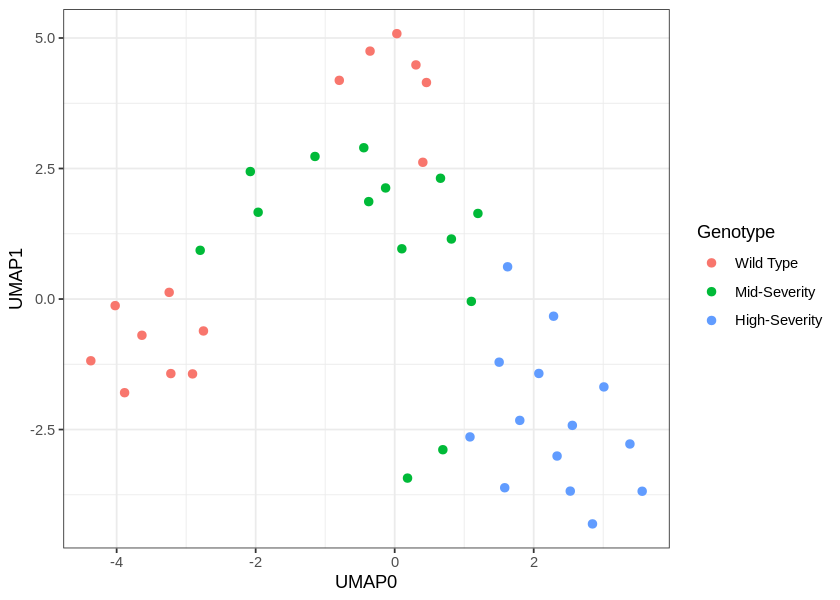

In [5]:
# umap
width <- 7
height <- 5
options(repr.plot.width = width, repr.plot.height = height)
umap_df <- umap::umap((features_df), n_neighbors = 7, min_dist = 0.7, n_components = 2, metric = "cosine")
umap_df <- as.data.frame(umap_df$layout)
colnames(umap_df) <- c("UMAP0", "UMAP1")
umap_df <- cbind(metadata_df, umap_df)

# plot umap
umap_plot <- (
    ggplot(umap_df, aes(x = UMAP0, y = UMAP1, color = Metadata_genotype))
    + geom_point(size = 2)

    + theme_bw()
    + guides(color = guide_legend(title = "Genotype"))
)
umap_plot
# save the plot
ggsave("custom_aggregated_umap_plot_genotype.png", path = file.path(fig_path), width = width, height = height, units = "in", dpi = 600)



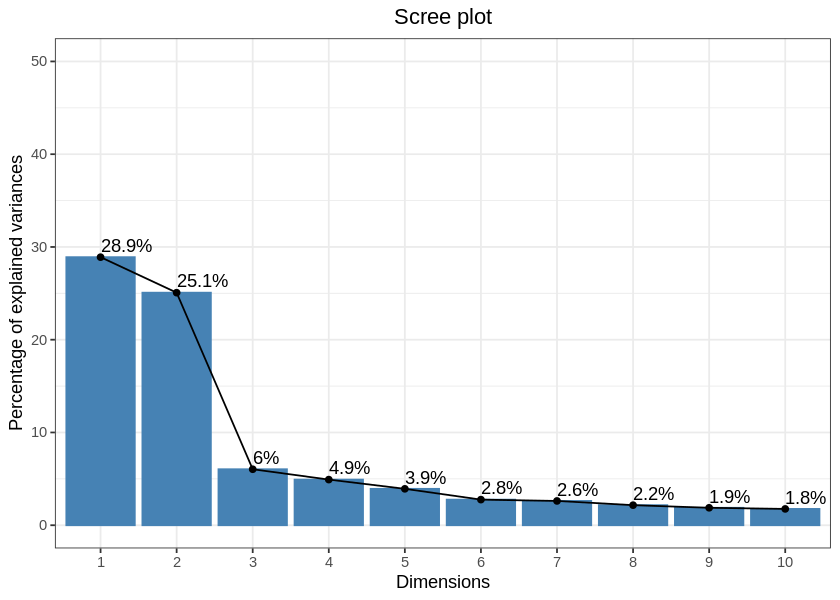

In [6]:

# Apply PCA
res.pca <- prcomp(features_df, scale = TRUE)

# Create scree plot
scree_plot <- fviz_eig(res.pca, addlabels = TRUE, ylim = c(0, 50))
scree_plot <- (
    scree_plot
    + theme_bw()
    # title centered
    + theme(plot.title = element_text(hjust = 0.5))
)
scree_plot
# save the plot
ggsave("custom_aggregated_scree_plot.png", path = file.path(fig_path), width = width, height = height, units = "in", dpi = 600)

### PCA with genotype

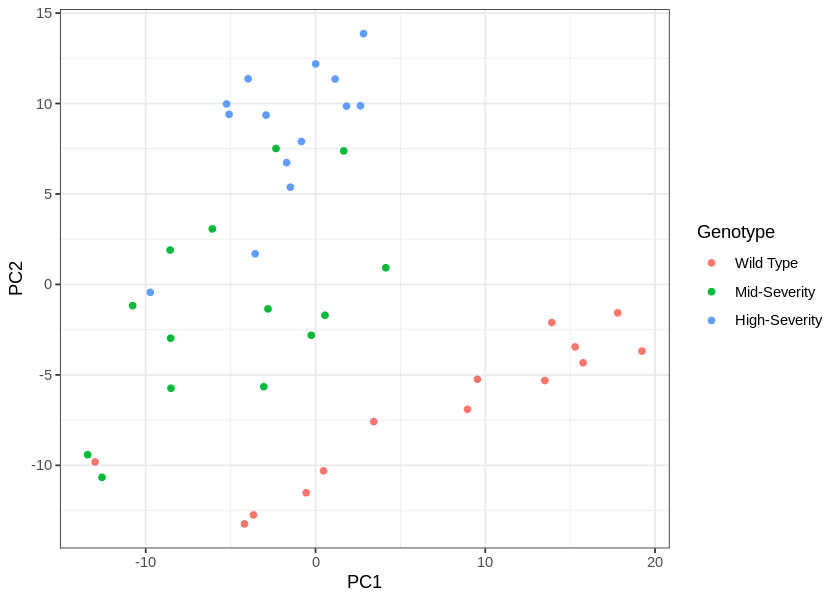

In [7]:
# pca analysis
pca_df <- as.data.frame(res.pca$x)
pca_df <- cbind(metadata_df, pca_df)

# plot pca
pca_plot <- (
    ggplot(pca_df, aes(x = PC1, y = PC2, color = Metadata_genotype))
    + geom_point()
    + theme_bw()
    + guides(color = guide_legend(title = "Genotype"))
)
pca_plot
# save the plot
ggsave("custom_aggregated_pca_plot_genotype.png", path = file.path(fig_path), width = width, height = height, units = "in", dpi = 600)


In [8]:
# save the pca results as a parquet file
arrow::write_parquet(pca_df, pca_file_path)